In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
from torch import nn

In [22]:
torch.__version__

'2.1.1'

In [23]:
# ignore all warnings as sometimes these models throw random warnings
import warnings
warnings.warn = lambda *a, **kw: False

In [24]:
KFOLDER = "/Users/jeffhu/cs229b/proj/img"

In [25]:
df = pd.read_csv("bitcoin.csv")
df['timestamp'] = pd.to_datetime(df['timestamp']) # convert the timestamp strings into datetimes
df.head()

,timestamp,prices,market_caps,total_volumes
0,2013-04-28,135.30,1.500518e+09,0.0
1,2013-04-29,141.96,1.575032e+09,0.0
2,2013-04-30,135.30,1.501657e+09,0.0
3,2013-05-01,117.00,1.298952e+09,0.0
4,2013-05-02,103.43,1.148668e+09,0.0


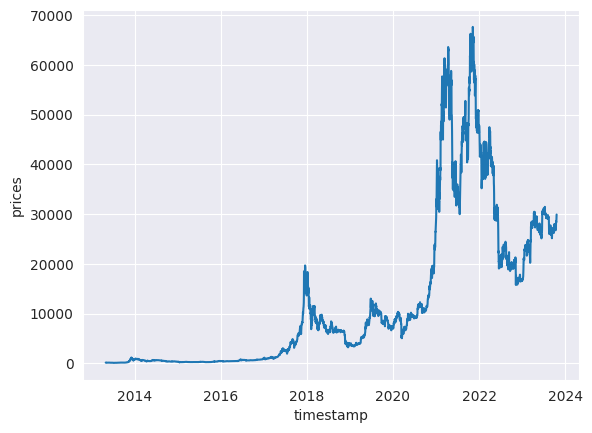

In [26]:
with sns.axes_style("darkgrid"):
    sns.lineplot(x=df['timestamp'], y=df['prices'])

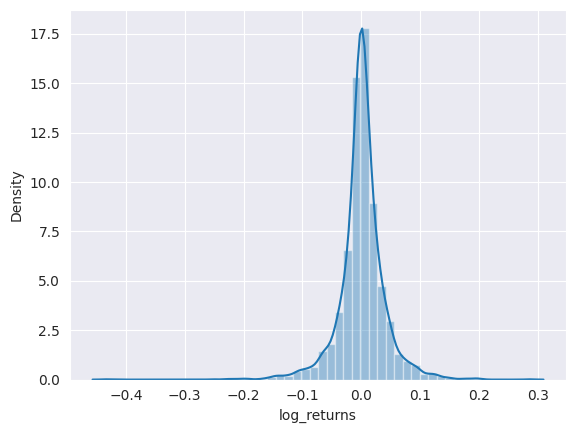

In [27]:
# 100x logged returns
df['log_returns'] = np.log(df['prices']) - np.log(df['prices']).shift(1)
df['log_returns_scaled'] = np.multiply(df['log_returns'], 100)
returns = pd.DataFrame(df['log_returns'].dropna())
with sns.axes_style("darkgrid"):
    sns.distplot(returns['log_returns'])

In [28]:
# CREATE A FUNCTION THAT CALCULATE REALIZED VOLATILITY
# FROM SAILY LOG RETURNS
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

In [29]:
realized_volatility_daily(df["log_returns"])

0.039800176515436325

In [30]:
INTERVAL_WINDOW = 30
n_future = 7

# GET BACKWARD LOOKING REALIZED VOLATILITY
df['vol_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY 
df['vol_future'] = df.log_returns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)

In [31]:
df.dropna(inplace=True) # drop NaN values produced by shifts

In [32]:
df.head()

,timestamp,prices,market_caps,total_volumes,log_returns,log_returns_scaled,vol_current,vol_future
30,2013-05-28,129.179,1.448116e+09,0.0,0.001503,0.150292,0.067346,0.035890
31,2013-05-29,132.130,1.481782e+09,0.0,0.022587,2.258725,0.066884,0.035813
32,2013-05-30,127.401,1.429309e+09,0.0,-0.036447,-3.644669,0.066631,0.030177
33,2013-05-31,127.980,1.436387e+09,0.0,0.004534,0.453441,0.060927,0.031741
34,2013-06-01,129.090,1.449500e+09,0.0,0.008636,0.863583,0.056486,0.031865


# Train test split

In [33]:
from torch.autograd import Variable
import torch

In [34]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size

train_idx, test_idx = df.index[:train_size], df.index[train_size:]

ts_train, ts_test = df.timestamp[:train_size], df.timestamp[train_size:]
X_train, X_test, y_train, y_test = df.vol_current[:train_size], df.vol_current[train_size:], df.vol_future[:train_size], df.vol_future[train_size:]

X_train.head()

30    0.067346
31    0.066884
32    0.066631
33    0.060927
34    0.056486
Name: vol_current, dtype: float64

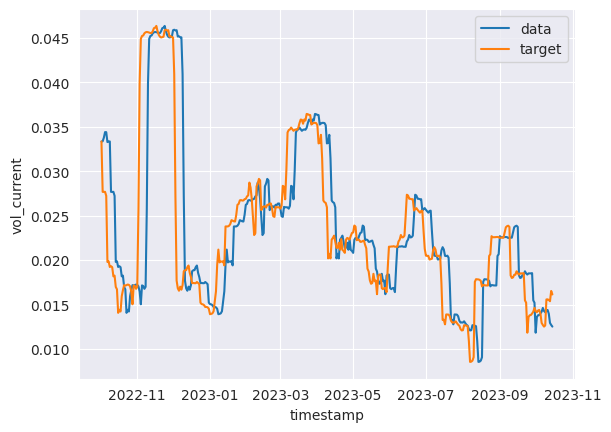

In [35]:
with sns.axes_style("darkgrid"):
    sns.lineplot(x=ts_test, y=X_test, label="data")
    sns.lineplot(x=ts_test, y=y_test, label="target")

## Preprocess data for neural networks

In [36]:
def create_sequences(data, seq_length):
    return [data[i:i+seq_length].values for i in range(len(data)-seq_length)]

seq_length = 14
X_train, X_test = create_sequences(X_train, seq_length), create_sequences(X_test, seq_length)
y_train, y_test = y_train[seq_length:].values, y_test[seq_length:].values

X_train = Variable(torch.tensor(X_train).float())
y_train = Variable(torch.tensor(y_train).float())
X_test = Variable(torch.tensor(X_test).float())
y_test = Variable(torch.tensor(y_test).float())

# FC Neural Net

In [37]:
class SimpleNN(nn.Module):
    def __init__(self, n_past):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(n_past, 1)

    def forward(self, x):
        x = x.unsqueeze(0)
        x = self.flatten(x)
        return self.linear(x)

model = SimpleNN(seq_length)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [38]:
epochs = 100

for i in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00001731
epoch:  26 loss: 0.00005534
epoch:  51 loss: 0.00005945
epoch:  76 loss: 0.00005929
epoch:  99 loss: 0.0000586749


In [39]:
forecasts = []
for x in X_test:
    forecasts.append(model(x))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jeffhu/cs229b/proj/img/NN_vol.png'

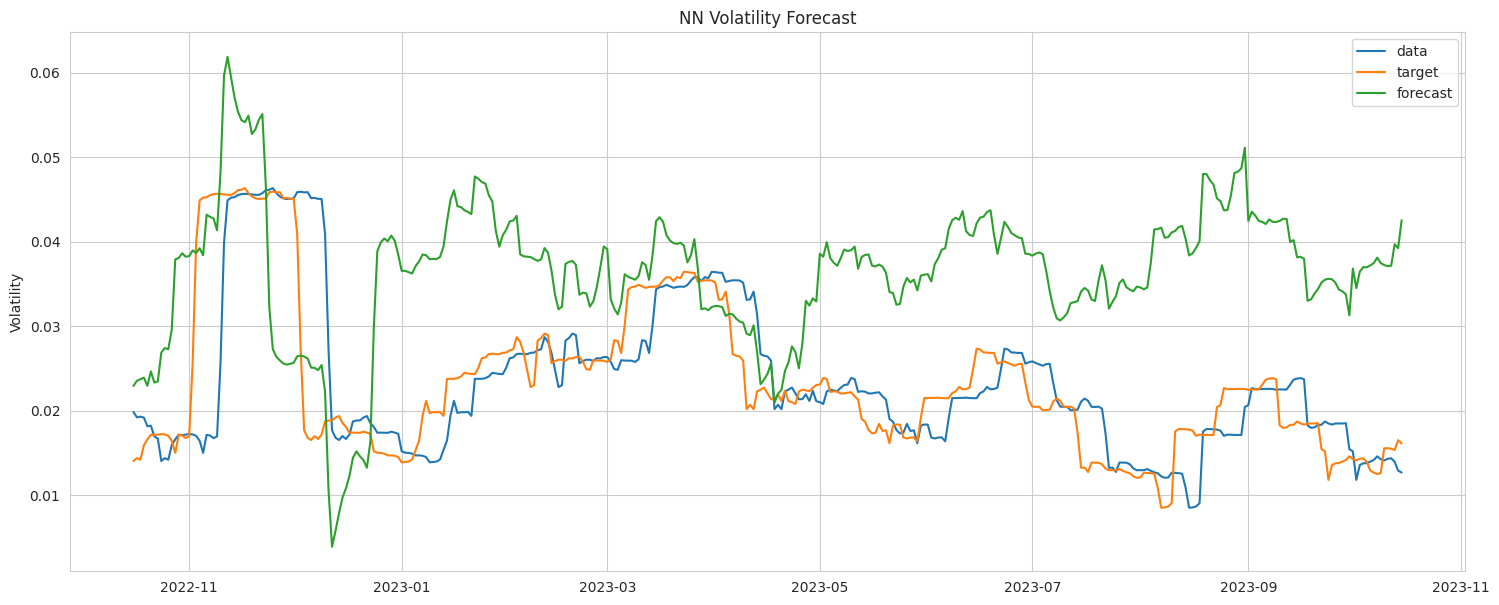

In [40]:
n = len(forecasts)
ts_test_clipped = ts_test[len(ts_test)-n:]
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(18,7))
    sns.lineplot(x=ts_test_clipped, y=[x[-1].item() for x in X_test], label="data")
    sns.lineplot(x=ts_test_clipped, y=y_test.numpy(), label="target")
    sns.lineplot(x=ts_test_clipped, y=[f.item() for f in forecasts], label="forecast")
    ax.set(xlabel='', 
           ylabel='Volatility', 
           title='NN Volatility Forecast')
    plt.savefig(os.path.join(KFOLDER, "NN_vol.png"), dpi=300, bbox_inches='tight')

# LSTM

In [43]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

lstm = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters())

In [44]:
epochs = 150

for i in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        lstm.hidden_cell = (torch.zeros(1, 1, lstm.hidden_layer_size),
                            torch.zeros(1, 1, lstm.hidden_layer_size))

        y_pred = lstm(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00000855
epoch:  26 loss: 0.00000579


KeyboardInterrupt: 

In [ ]:
forecasts = []
for x in X_test:
    lstm.hidden_cell = (torch.zeros(1, 1, lstm.hidden_layer_size),
                            torch.zeros(1, 1, lstm.hidden_layer_size))
    forecasts.append(lstm(x))

In [ ]:
n = len(forecasts)
ts_test_clipped = ts_test[len(ts_test)-n:]
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(18,7))
    sns.lineplot(x=ts_test_clipped, y=[x[-1].item() for x in X_test], label="data")
    sns.lineplot(x=ts_test_clipped, y=y_test.numpy(), label="target")
    sns.lineplot(x=ts_test_clipped, y=[f.item() for f in forecasts], label="forecast")
    ax.set(xlabel='', 
           ylabel='Volatility', 
           title='LSTM Volatility Forecast')
    plt.savefig(os.path.join(KFOLDER, "NN_vol.png"), dpi=300, bbox_inches='tight')

[tensor([-0.0906], grad_fn=<SelectBackward0>),
 tensor([-0.0906], grad_fn=<SelectBackward0>),
 tensor([-0.0906], grad_fn=<SelectBackward0>),
 tensor([-0.0906], grad_fn=<SelectBackward0>),
 tensor([-0.0906], grad_fn=<SelectBackward0>),
 tensor([-0.0906], grad_fn=<SelectBackward0>),
 tensor([-0.0906], grad_fn=<SelectBackward0>),
 tensor([-0.0906], grad_fn=<SelectBackward0>),
 tensor([-0.0906], grad_fn=<SelectBackward0>),
 tensor([-0.0906], grad_fn=<SelectBackward0>),
 tensor([-0.0906], grad_fn=<SelectBackward0>),
 tensor([-0.0906], grad_fn=<SelectBackward0>),
 tensor([-0.0906], grad_fn=<SelectBackward0>),
 tensor([-0.0906], grad_fn=<SelectBackward0>),
 tensor([-0.0906], grad_fn=<SelectBackward0>),
 tensor([-0.0906], grad_fn=<SelectBackward0>),
 tensor([-0.0906], grad_fn=<SelectBackward0>),
 tensor([-0.0906], grad_fn=<SelectBackward0>),
 tensor([-0.0906], grad_fn=<SelectBackward0>),
 tensor([-0.0906], grad_fn=<SelectBackward0>),
 tensor([-0.0906], grad_fn=<SelectBackward0>),
 tensor([-0.0